In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import cv2
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import keras.backend as B
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pycuda.driver as cuda
from keras.preprocessing.image import ImageDataGenerator ,img_to_array
from keras.metrics import binary_crossentropy
from keras.models import Sequential , Model
from keras.layers import BatchNormalization , Conv2D , Dense , Activation , Flatten , MaxPool2D , Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings('ignore')
import time
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train', 'test_ApKoW4T.csv', 'sample_submission_ns2btKE.csv']


In [2]:
if (torch.cuda.is_available()):
    cuda.init()

    #Get ID of CUDA device
    ID= torch.cuda.current_device()
    #Get CUDA device name
    print(cuda.Device(ID).name())

    #set the GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = str(ID)

Tesla P100-PCIE-16GB


In [3]:
rcsv= pd.read_csv("../input/train/train.csv")
testcvs = pd.read_csv("../input/test_ApKoW4T.csv")
data_path = "../input/train/images/"
path = os.path.join(data_path , "*jpg")

In [4]:
files = glob.glob(path)
data=[]
for file in files:
    image = cv2.imread(file)
    data.append(image)

In [5]:
train_images = data[:6252]
test_images= data[6252:]

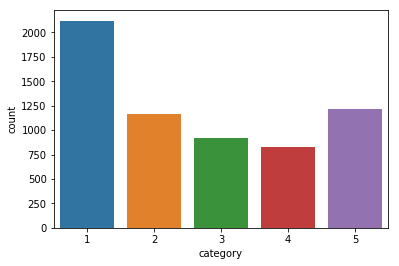

In [6]:
sns.countplot(x='category' , data=rcsv)

* Since the data is imbalanced a bit, we will use keras inbuilt function for real time Data Augmentation of images

In [7]:
category = {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

## Visualising Images in Each Class

In [8]:
def plot_class(cat):
    
    fetch = rcsv.loc[rcsv['category']== category[cat]][:9]
    fig = plt.figure(figsize=(20,15))
    
    for i , index in enumerate(fetch.index ,1):
        plt.subplot(3,3 ,i)
        plt.imshow(train_images[index])
        plt.xlabel(cat + " (Index:" +str(index)+")" )
    plt.show()

In [9]:
#plot_class('Cargo')

In [10]:
#plot_class('Military')

In [11]:
#plot_class('Carrier')

In [12]:
#plot_class('Cruise')

In [13]:
#plot_class('Tankers')

## Image Preprocessing

In [14]:
class ImagePreprocessing:
    
    def __init__(self,train_images , test_imges , height , length , dataframe):
        
        self.train_images =train_images
        self.test_images  =test_images
        self.height = height
        self.length = length
        self.dataframe = dataframe
    
    def Resize(self,TAG):
        processed_images =[]
        if TAG == 'Train':
            for i in range(len(self.train_images)):
                im= cv2.resize(self.train_images[i] , dsize=(self.height , self.height))
                processed_images.append(im)
        elif TAG== 'Test':
            for i in range(len(self.test_images)):
                im= cv2.resize(self.test_images[i] , dsize=(self.height , self.height))
                processed_images.append(im)
        return processed_images
    
    def Reshape(self):
        #resizing Images
        self.rez_train_image = self.Resize('Train')
        self.rez_test_image  = self.Resize('Test')
        #fetching labels for training and testing
        self.train_labels    = self.dataframe['category'][:self.length]
        
        #converting into array 
        self.label_array = self.toarray(self.train_labels)
        
        #reshaping label array
        self.labels      = self.label_array.reshape(len(self.label_array) , 1)
        
        #reshaping images
        self.pro_images = np.reshape(self.rez_train_image , (len(self.rez_train_image),self.height,self.height,3))
        self.test_pro_images = np.reshape(self.rez_test_image , (len(self.rez_test_image) ,self.height,self.height,3))
        
        return  self.pro_images , self.labels , self.test_pro_images
    
    
    def toarray(self,series):
        return np.array(series)
    
    def splitdata(self,TRAIN_images, LABELS):
        X_train , X_val , Y_train , Y_val = train_test_split(TRAIN_images , LABELS , test_size=0.2 , random_state=42)
        return X_train , X_val , Y_train , Y_val
    
    def OneHot(self,x):
        onehotencoder = OneHotEncoder(categorical_features = [0])
        x = onehotencoder.fit_transform(x).toarray()
        return x

## Image Augmentation
I refer to the artilcle for the idea of Augmentation. **[Here](https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8)** For data generator I refered this [article](https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad)

In [15]:
datagen = ImageDataGenerator(featurewise_center=True,  
                             featurewise_std_normalization =False ,
                             rotation_range=20, 
                             horizontal_flip=True,
                             width_shift_range=0.20 , fill_mode = 'nearest',
                             height_shift_range=0.20  )

In [37]:
preprocess = ImagePreprocessing(train_images , test_images , height=150 , length= 6252 , dataframe=rcsv)
rez_images , LABELS , test_rez_images = preprocess.Reshape()
onehot_labels = preprocess.OneHot(LABELS)
X_train , X_val , Y_train , Y_val = preprocess.splitdata(rez_images , onehot_labels )

In [31]:
# save_image_path = "/kaggle/working/IMAGES"
# if not os.path.exists(save_image_path):
#     os.mkdir(save_image_path)







# T0 = time.time()
# for image , label in zip(rez_images , LABELS):
#     image =np.expand_dims(image ,0)
#     datagen.fit(image)
#     name = "shiptype_{}".format(label)
#     for x , val in zip(datagen.flow(image,label,batch_size=1,save_to_dir=save_image_path,save_prefix=name,save_format='jpg'), range(5)):
#         pass
# print("Total time for training: {}".format(time.time()-T0))





# files = glob.glob(os.path.join(save_image_path,"*jpg"))
# imagedata=[]
# labeldata=[]
# for file in files:
#     label = file.split("/")[-1][10]
#     image = cv2.imread(file)
#     image = cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
#     imagedata.append(image)
#     labeldata.append(int(label))



# imagedata = np.reshape(imagedata , (len(imagedata) , 150,150,3))
# labeldata = np.reshape(labeldata , (len(labeldata) ,1))
# IMAGES = np.concatenate((rez_images , imagedata), axis=0)
# LABELDATA = np.concatenate((LABELS , labeldata) , axis=0)




# IMAGESlist =[]
# for i in range(len(IMAGES)):
#     IMAGESlist.append(IMAGES[i].reshape(1,-1).transpose())




# IMAGES.tolist()



# df = pd.DataFrame([IMAGESlist])





In [24]:
# fig = plt.figure(figsize=(20,15))
    
# for i in range(1,10,1):
#     plt.subplot(3,3 ,i)
#     plt.imshow(IMAGES[i])
#     plt.xlabel(LABELDATA[i])
# plt.show()

### Splitting the data

In [25]:
# X_train , X_val , Y_train , Y_val = preprocess.splitdata(imagedata , labeldata )
# Y_train = np.reshape(preprocess.toarray(Y_train) , (len(Y_train),1))
# Y_val = np.reshape(preprocess.toarray(Y_val) , (len(Y_val),1))
# X_train = np.reshape(preprocess.toarray(X_train) , (len(X_train),150,150,3))
# X_val = np.reshape(preprocess.toarray(X_val) , (len(X_val),150,150,3))
# Y_val = preprocess.toarray(Y_val)
# labels = preprocess.OneHot(Y_train)
# val_labels = preprocess.OneHot(Y_val)

In [56]:
def Mymodel(input_shape , L2):
    
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu', kernel_regularizer=L2,padding='same',input_shape=input_shape))
    model.add(MaxPool2D((2,2) ,strides=(2,2), padding='same'))
    model.add(Conv2D(64 , kernel_size=(3,3),activation='relu', padding='same'))
    model.add(MaxPool2D((2,2) ,strides=(2,2), padding='same'))
    #model.add(Conv2D(64 , kernel_size=(3,3),activation='relu', padding='same', kernel_regularizer=L2))
    #model.add(MaxPool2D((2,2) ,strides=(2,2), padding='same'))
    
    #model.add(Conv2D(128 , kernel_size=(3,3),activation='relu', padding='same'))
    #model.add(MaxPool2D((2,2) ,strides=(2,2), padding='same'))
    #model.add(Conv2D(128 , kernel_size=(3,3),activation='relu', padding='same'))
    #model.add(Conv2D(128 , kernel_size=(3,3),activation='relu', padding='same',  kernel_regularizer=L2))
    #model.add(MaxPool2D((2,2) ,strides=(2,2), padding='same'))
    
    #model.add(Conv2D(256 , kernel_size=(3,3),activation='relu', padding='same'))
    #model.add(Conv2D(256 , kernel_size=(3,3),activation='relu', padding='same'))
    #model.add(Conv2D(256 , kernel_size=(3,3),activation='relu', padding='same', kernel_regularizer=L2))
    #model.add(MaxPool2D((2,2) ,strides=(2,2), padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(512 , activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    
    #model.add(Dense(256 , activation='relu'))
    #model.add(BatchNormalization())
    
    #model.add(Dense(128 , activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    model.add(Dense(64 , activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    model.add(Dense(32 , activation='relu', kernel_regularizer=None))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    model.add(Dense(16 , activation='relu', kernel_regularizer=None))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    model.add(Dense(8 , activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    model.add(Dense(5 , activation='softmax'))
    
    model.compile(optimizer=Adam(lr=0.001) , loss='categorical_crossentropy' , metrics=['accuracy'])
    
    return model

In [57]:
#X_train = datagen.fit(X_train)
#X_val = datagen.fit(X_val)
train_generator = datagen.flow(X_train , Y_train)
val_generator = datagen.flow(X_val , Y_val)

TypeError: object of type 'NoneType' has no len()

In [58]:
model = Mymodel((150,150,3), None)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 92416)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                5914688   
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
__________

In [59]:
# T0 = time.time()
# history = model.fit_generator(train_generator , steps_per_epoch=300 , epochs=25 , validation_data=val_generator , validation_steps=300)
# #history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=512,epochs=20)
# print("Total time for training: {}".format(time.time()-T0))

Epoch 1/25
300/300 [==============================] - 79s 264ms/step - loss: 1.5785 - acc: 0.3316 - val_loss: 1.5629 - val_acc: 0.3324
Epoch 2/25
299/300 [============================>.] - ETA: 0s - loss: 1.5525 - acc: 0.3405

KeyboardInterrupt: 

In [ ]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.savefig("../working/Accuracy.png") 
# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.savefig("../working/Loss.png")
 
# plt.show()